# From biological to Artificial neuron

## The Perceptron

In [37]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target == 0  # Iris Setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [38]:
per_clf.predict([[2, 0.5], [3, 1]])

array([ True, False])

The Perceptron is equivalent to an SGDClassifier, implemented as following code cell.

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42
)
sgd_clf.fit(X, y)
assert (sgd_clf.intercept_ == per_clf.intercept_).all()
assert (sgd_clf.coef_ == per_clf.coef_).all()

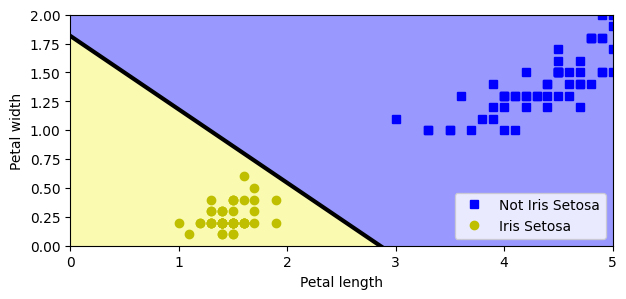

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]

axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.legend(loc="lower right")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([0, 5, 0, 2])
plt.show()

**Activation function**

Here we plot some popular activation functions and their derivatives.

In [41]:
from scipy.special import expit as sigmoid


def relu(z):
    return np.maximum(z, 0)


def derivate(f, z, epsilon=1e-6):
    return (f(z + epsilon) - f(z)) / epsilon


max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

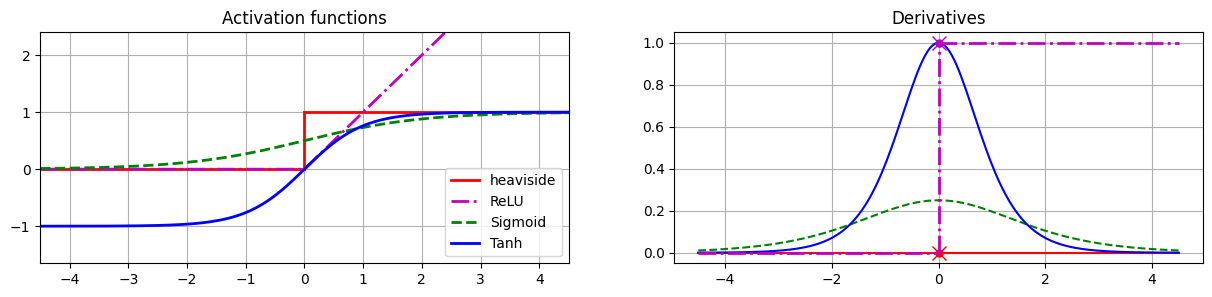

In [42]:
plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot([0, 0], [0, 1], "r-", linewidth=2)
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.grid()
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.title("Activation functions")
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(z, derivate(sigmoid, z), "g--")
plt.plot(z, derivate(np.sign, z), "r-")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivate(np.tanh, z), "b-")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid()
plt.title("Derivatives")

plt.show()

## Regression MLPs

We can train MLP using MLPRegressor in scikit-learn. <br>

Its parameters is very similar to Linear Regression, so here I will just explain the unique parameters of MLPRegressor:
- hidden_layer_sizes: A list contains the number of neuron in each hidden layer.
- activation: Activation functions used in the neural network
- solver: the weight optimization algorithm, default is Adam
- alpha: the hyperparameter for regularization, default is a bit of regularization.

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

mlp_reg = MLPRegressor([50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_predict, squared=False)

In [44]:
rmse

0.5053326657968512

The error is about 0.505, comparable with a Random Forest, which is not bad for our first try!

## Classification MLPs

In [45]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000, random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras

## Building an Image Classifier Using the Sequential API

### Using Keras to load the dataset

- We start by loading the Fashion MNIST dataset. Keras has a number of function to load popular datasets in `tf.keras.datasets`. 
- The dataset is already shuffled and split into a training set (60,000 images) and a test set (10,000 images). We'll hold out the last 5,000 images from the training set for validation.

In [46]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 55,000 greyscale images, each 28x28 pixels.

In [47]:
X_train.shape

(55000, 28, 28)

Each pixel intensities is represented as a byte (0 to 255).

In [48]:
X_train.dtype

dtype('uint8')

We scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing them by 255. 

In [49]:
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

We can plot an image using Matplotlib's `imshow()` function, with a `'binary'` color map.

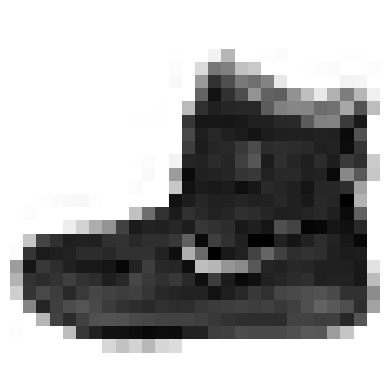

In [50]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9.

In [51]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [52]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

So the first image in the training set is an ankle boot.

In [53]:
class_names[y_train[0]]

'Ankle boot'

Here we plot the first 40 images in the training set. 

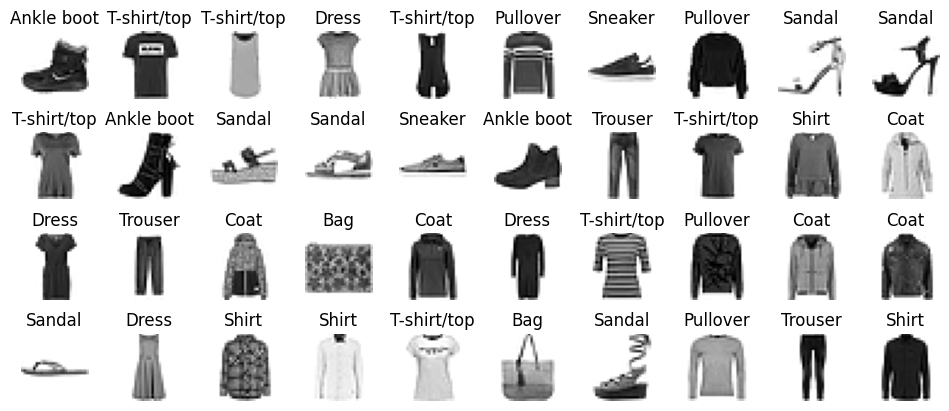

In [54]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary")
        plt.axis("off")
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

### Creating the model using the sequential API

In [55]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

We go through this code line by line in note.md.

It's often preferable to pass a list of layers when creating the `Sequential` model. You can slo drop the `Input` layer and specify the `input_shape` in the first layer.

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
from keras.src.engine.sequential import Sequential

model: Sequential = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


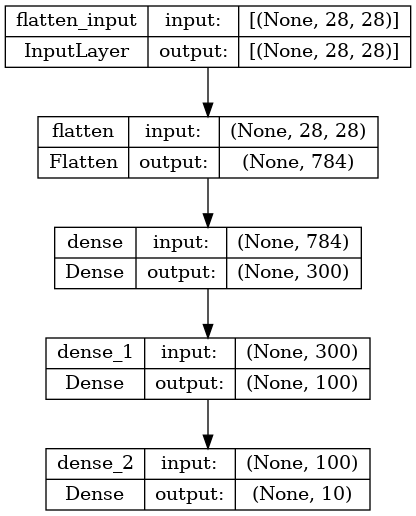

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

We can get a list of a model's layers by using the `layers` attribute, or use the `get_layer()` method to access the layer by name.

In [59]:
model.layers

In [60]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [61]:
model.get_layer("dense") is hidden1

True

All the parameters of a layer cna be accessed using its `get_weights()` and `set_weights()` methods. For a `Dense` layer, this includes both the connection weights and the bias terms.

In [62]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.03070598,  0.03173504, -0.04569614, ...,  0.04125535,
        -0.04635586, -0.03413455],
       [ 0.05608445,  0.05481422,  0.03391363, ..., -0.03948735,
         0.05138807, -0.02865971],
       [ 0.01087506,  0.04480949,  0.06690422, ..., -0.05162045,
        -0.05618831,  0.04159168],
       ...,
       [ 0.00234686,  0.0369864 , -0.03121665, ...,  0.03920893,
        -0.02402355,  0.06926861],
       [-0.0612658 , -0.03101366,  0.0141547 , ...,  0.00374544,
         0.01522275, -0.03594603],
       [-0.0574531 , -0.06309553, -0.05912869, ..., -0.04052007,
         0.00022176, -0.05771013]], dtype=float32)

In [63]:
weights.shape

(784, 300)

In [64]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [65]:
biases.shape

(300,)

### Compiling the model

In [66]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)

This is equivalent to:

In [67]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)

This code shows how to convert class ids to one-hot vectors.

In [68]:
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: It's important to set `num_classes` when the number of classes is greater than the maximum class ids in the sample.

This code shows how to convert one-hot vectors to class ids

In [69]:
np.argmax(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ],
    axis=1,
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [70]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
 921/1719 [===============>..............] - ETA: 1s - loss: 0.8619 - sparse_categorical_accuracy: 0.7148

1719/1719 [==============================] - 4s 2ms/step - loss: 0.7225 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.8262
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.4613 - val_sparse_categorical_accuracy: 0.8322
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4413 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.4229 - val_sparse_categorical_accuracy: 0.8490
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4154 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.3968 - val_sparse_categorical_accuracy: 0.8582
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8613 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8582
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3772 - sparse_categoric

Here, we try to have some errors, so the following code blocks will have errors and that's expected.

Here, I try to fit the model with inputs and outputs of the wrong shape. It throws a `ValueError`, as the model expects an matrix of 784 columns. 

In [71]:
model.fit([1], [2])

ValueError: in user code:

    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 784, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=True
      • mask=None


Here, I try to compile another model with `loss="categorical_crossentropy"` instead of `loss="sparse_categorical_crossentropy"`.

In [ ]:
test_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=[28, 28]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
test_model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
test_model.fit(X_train, y_train)

ValueError: in user code:

    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


Keras expects the label is an array of 10 elements vectors, and got an array of 1 element vector instead.

Here, I try to remove the `Flatten` layer.

In [ ]:
test_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
test_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
test_model.fit(
    X_train,
    y_train,
)

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_3771/504457178.py", line 12, in <module>

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/home/daoxuantan/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [896,10] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_455138]

- Looks like there is a mismatch between the shape of the model's output (logits) and the actual labels.
- In TensorFlow, the first dimension of your data often represents the batch size.
- In our case, it seems like the model is processing 896 samples at once, but the labels are only provided for 32 samples. The reason why 896 occurs is 896 = 28x32, and Keras loads 32 samples in a mini-batch.

We can invoke some useful attributes of `history` to inspect the training process.

In [72]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [73]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


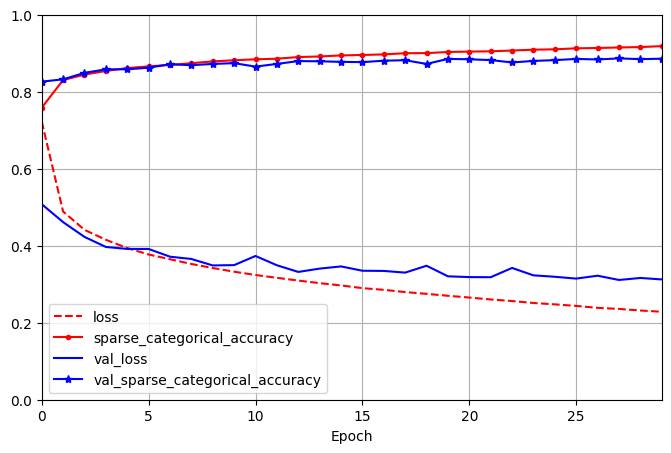

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 29],
    ylim=[0, 1],
    grid=True,
    xlabel="Epoch",
    style=["r--", "r.-", "b-", "b*-"],
)
plt.legend(loc="lower left")
plt.show()

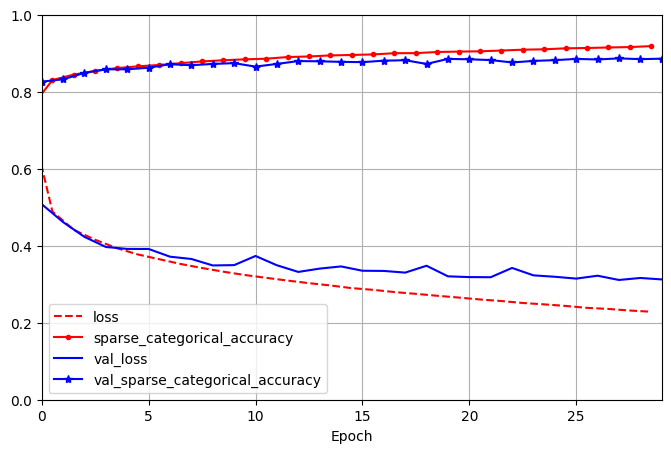

In [75]:
# This code shows how to shift the training curve by half of epoch to the left
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r.-", "b-", "b*-"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([0, 29, 0, 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [76]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3278 - sparse_categorical_accuracy: 0.8834


[0.32784217596054077, 0.883400022983551]

### Using the model to make predictions

In [77]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 43ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [78]:
import numpy as np

y_predict = y_proba.argmax(axis=-1)
y_predict

array([9, 2, 1])

In [79]:
np.array(class_names)[y_predict]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [80]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

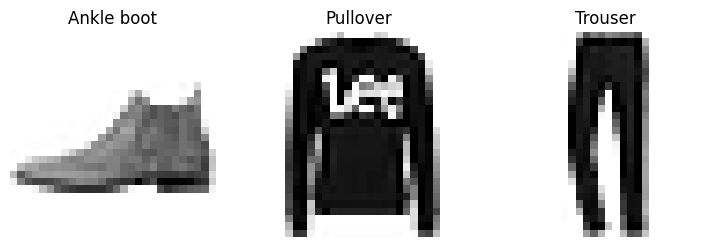

In [81]:
plt.figure(figsize=(9, 3))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_new[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building a Regression MLP Using the Sequential API

In [82]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

In [83]:
import tensorflow as tf

tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(
    input_shape=X_train.shape[1:]
)  # We use 1: because we ignore the number of samples
model = tf.keras.Sequential(
    [
        norm_layer,
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="mse", metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_predict = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7859 - root_mean_squared_error: 0.8865 - val_loss: 0.5257 - val_root_mean_squared_error: 0.7250
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3820 - root_mean_squared_error: 0.6180 - val_loss: 2.3612 - val_root_mean_squared_error: 1.5366
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3771 - root_mean_squared_error: 0.6141 - val_loss: 0.3438 - val_root_mean_squared_error: 0.5863
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3474 - root_mean_squared_error: 0.5894 - val_loss: 1.3409 - val_root_mean_squared_error: 1.1580
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3333 - root_mean_squared_error: 0.5773 - val_loss: 0.3192 - val_root_mean_squared_error: 0.5650
Epoch 6/20
287/363 [======================>.......] - ETA: 0s - loss: 0.3193 - root_mean_squared_error: 0.5651

363/363 [==============================] - 0s 1ms/step - loss: 0.3196 - root_mean_squared_error: 0.5653 - val_loss: 0.3072 - val_root_mean_squared_error: 0.5542
Epoch 7/20
363/363 [==============================] - 0s 909us/step - loss: 0.3211 - root_mean_squared_error: 0.5667 - val_loss: 0.9324 - val_root_mean_squared_error: 0.9656
Epoch 8/20
363/363 [==============================] - 0s 916us/step - loss: 0.3072 - root_mean_squared_error: 0.5543 - val_loss: 2.5343 - val_root_mean_squared_error: 1.5919
Epoch 9/20
363/363 [==============================] - 0s 958us/step - loss: 0.3145 - root_mean_squared_error: 0.5608 - val_loss: 2.7336 - val_root_mean_squared_error: 1.6533
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3232 - root_mean_squared_error: 0.5685 - val_loss: 1.5194 - val_root_mean_squared_error: 1.2326
Epoch 11/20
363/363 [==============================] - 1s 2ms/step - loss: 0.2942 - root_mean_squared_error: 0.5424 - val_loss: 0.3417 - val_roo

In [84]:
rmse_test

0.5391181707382202

In [85]:
y_predict

array([[0.5111544],
       [0.9448445],
       [5.321712 ]], dtype=float32)

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 8)                 17        
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 50)                450       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5618 (21.95 KB)
Trainable params: 5601 (21.88 KB)
Non-trainable params: 17 (72.00 Byte)
__________________

## Building Complex Models Using the Functional API

In [87]:
# reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [88]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([hidden2, normalized])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [89]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [90]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_predict = model.predict(X_new)

Epoch 1/20
345/363 [===========================>..] - ETA: 0s - loss: 1.4941 - root_mean_squared_error: 1.2223

363/363 [==============================] - 1s 2ms/step - loss: 1.4535 - root_mean_squared_error: 1.2056 - val_loss: 0.8872 - val_root_mean_squared_error: 0.9419
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4774 - root_mean_squared_error: 0.6909 - val_loss: 0.6625 - val_root_mean_squared_error: 0.8140
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4065 - root_mean_squared_error: 0.6376 - val_loss: 0.4235 - val_root_mean_squared_error: 0.6508
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3877 - root_mean_squared_error: 0.6226 - val_loss: 0.6845 - val_root_mean_squared_error: 0.8273
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3723 - root_mean_squared_error: 0.6101 - val_loss: 1.1438 - val_root_mean_squared_error: 1.0695
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3688 - root_mean_squared_error: 0.6073 - val_loss: 1.3022 - val_root_mean_s

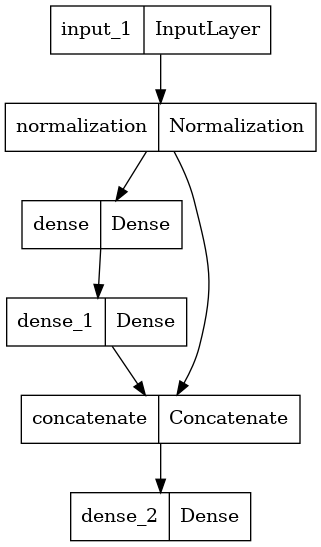

In [91]:
tf.keras.utils.plot_model(model)

In [92]:
tf.random.set_seed(42)

In [93]:
input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_new[:, :5], X_new[:, 2:]

In [95]:
norm_layer_deep.adapt(X_train_deep)
norm_layer_wide.adapt(X_train_wide)
history = model.fit(
    (X_train_wide, X_train_deep),
    y_train,
    epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), y_valid),
)
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_predict = model.predict((X_new_wide, X_new_deep))

Epoch 1/20


363/363 [==============================] - 1s 1ms/step - loss: 1.1400 - root_mean_squared_error: 1.0677 - val_loss: 0.6255 - val_root_mean_squared_error: 0.7909
Epoch 2/20
363/363 [==============================] - 0s 984us/step - loss: 0.4837 - root_mean_squared_error: 0.6955 - val_loss: 0.7896 - val_root_mean_squared_error: 0.8886
Epoch 3/20
363/363 [==============================] - 0s 872us/step - loss: 0.4477 - root_mean_squared_error: 0.6691 - val_loss: 0.4071 - val_root_mean_squared_error: 0.6381
Epoch 4/20
363/363 [==============================] - 0s 953us/step - loss: 0.4157 - root_mean_squared_error: 0.6447 - val_loss: 0.5438 - val_root_mean_squared_error: 0.7375
Epoch 5/20
363/363 [==============================] - 0s 970us/step - loss: 0.4028 - root_mean_squared_error: 0.6347 - val_loss: 0.9867 - val_root_mean_squared_error: 0.9933
Epoch 6/20
363/363 [==============================] - 0s 856us/step - loss: 0.3957 - root_mean_squared_error: 0.6290 - val_loss: 2.8613 - val_r

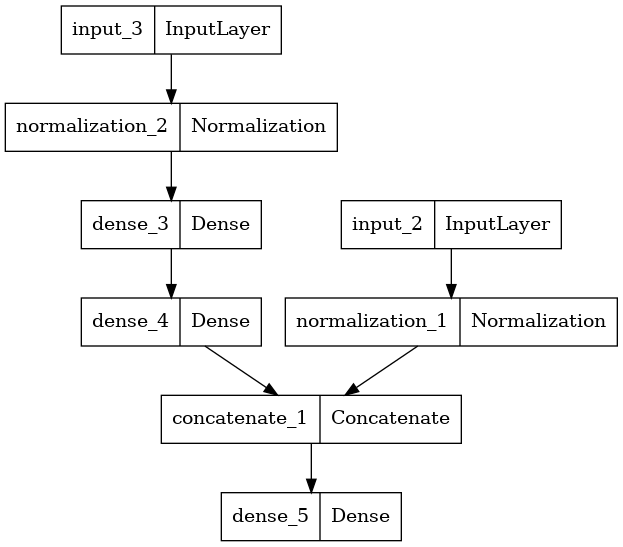

In [96]:
tf.keras.utils.plot_model(model)

Adding an auxiliary output for regularization:

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [98]:
input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output, aux_output])

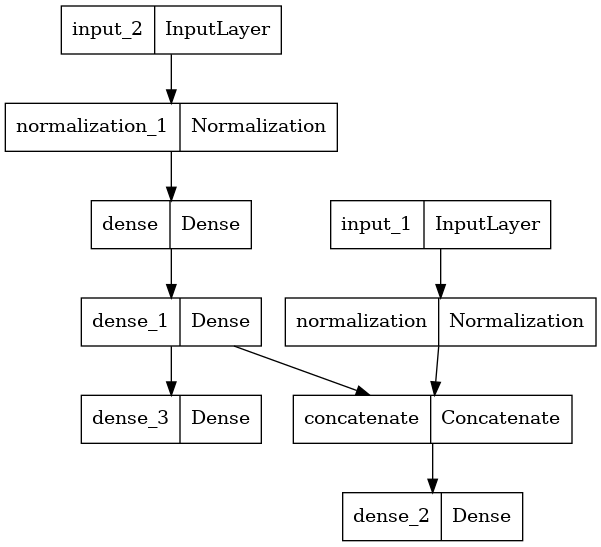

In [99]:
tf.keras.utils.plot_model(model)

In [100]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss=("mse", "mse"),
    loss_weights=(0.9, 0.1),
    metrics=["RootMeanSquaredError"],
)

In [101]:
norm_layer_deep.adapt(X_train_deep)
norm_layer_wide.adapt(X_train_wide)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
)

Epoch 1/20


363/363 [==============================] - 1s 1ms/step - loss: 1.5883 - dense_2_loss: 1.5366 - dense_3_loss: 2.0535 - dense_2_root_mean_squared_error: 1.2396 - dense_3_root_mean_squared_error: 1.4330 - val_loss: 1.2579 - val_dense_2_loss: 1.2392 - val_dense_3_loss: 1.4260 - val_dense_2_root_mean_squared_error: 1.1132 - val_dense_3_root_mean_squared_error: 1.1942
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5431 - dense_2_loss: 0.5181 - dense_3_loss: 0.7680 - dense_2_root_mean_squared_error: 0.7198 - dense_3_root_mean_squared_error: 0.8763 - val_loss: 0.7830 - val_dense_2_loss: 0.7623 - val_dense_3_loss: 0.9690 - val_dense_2_root_mean_squared_error: 0.8731 - val_dense_3_root_mean_squared_error: 0.9844
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4597 - dense_2_loss: 0.4464 - dense_3_loss: 0.5795 - dense_2_root_mean_squared_error: 0.6681 - dense_3_root_mean_squared_error: 0.7612 - val_loss: 0.5016 - val_dense_2_loss: 0.4700 - 

In [102]:
evaluate_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = evaluate_results

 99/162 [=================>............] - ETA: 0s - loss: 0.3340 - dense_2_loss: 0.3279 - dense_3_loss: 0.3892 - dense_2_root_mean_squared_error: 0.5726 - dense_3_root_mean_squared_error: 0.6238

162/162 [==============================] - 0s 915us/step - loss: 0.3307 - dense_2_loss: 0.3242 - dense_3_loss: 0.3892 - dense_2_root_mean_squared_error: 0.5694 - dense_3_root_mean_squared_error: 0.6239


In [103]:
evaluate_results = model.evaluate(
    (X_test_wide, X_test_deep), (y_test, y_test), return_dict=True
)
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = evaluate_results

 65/162 [===========>..................] - ETA: 0s - loss: 0.3469 - dense_2_loss: 0.3409 - dense_3_loss: 0.4017 - dense_2_root_mean_squared_error: 0.5838 - dense_3_root_mean_squared_error: 0.6338

162/162 [==============================] - 0s 856us/step - loss: 0.3307 - dense_2_loss: 0.3242 - dense_3_loss: 0.3892 - dense_2_root_mean_squared_error: 0.5694 - dense_3_root_mean_squared_error: 0.6239


In [104]:
evaluate_results

{'loss': 0.33068060874938965,
 'dense_2_loss': 0.32417476177215576,
 'dense_3_loss': 0.38923266530036926,
 'dense_2_root_mean_squared_error': 0.5693634748458862,
 'dense_3_root_mean_squared_error': 0.6238851547241211}

In [105]:
y_predict_main, y_predict_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 47ms/step


In [106]:
y_predict_tuple = model.predict((X_new_wide, X_new_deep))
y_predict = dict(zip(model.output_names, y_predict_tuple))

1/1 [==============================] - 0s 14ms/step


In [107]:
y_predict

{'dense_2': array([[0.46673042],
        [1.1972587 ],
        [3.6775022 ]], dtype=float32),
 'dense_3': array([[0.6622048],
        [1.2244645],
        [3.3108542]], dtype=float32)}

## Using the Subclassing API to Build Dynamic Models

In [108]:
class WideAndDeep(tf.keras.Model):
    def __init__(self, num_neurons=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to name the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(num_neurons, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(num_neurons, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output


# the next two lines is for reproducibility
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = WideAndDeep(num_neurons=30, activation="relu", name="my_humble_model")

In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.norm_layer_deep(X_train_deep)
model.norm_layer_wide(X_train_wide)
model.compile(
    loss="mse",
    optimizer=optimizer,
    loss_weights=[0.9, 0.1],
    metrics=["RootMeanSquaredError"],
)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
)

Epoch 1/10
323/363 [=========================>....] - ETA: 0s - loss: 78.4870 - output_1_loss: 35.8518 - output_2_loss: 462.2045 - output_1_root_mean_squared_error: 5.9876 - output_2_root_mean_squared_error: 21.4989  

363/363 [==============================] - 1s 2ms/step - loss: 71.1829 - output_1_loss: 33.3314 - output_2_loss: 411.8473 - output_1_root_mean_squared_error: 5.7733 - output_2_root_mean_squared_error: 20.2940 - val_loss: 15.4911 - val_output_1_loss: 16.6235 - val_output_2_loss: 5.2998 - val_output_1_root_mean_squared_error: 4.0772 - val_output_2_root_mean_squared_error: 2.3021
Epoch 2/10
363/363 [==============================] - 0s 978us/step - loss: 8.0426 - output_1_loss: 8.7019 - output_2_loss: 2.1093 - output_1_root_mean_squared_error: 2.9499 - output_2_root_mean_squared_error: 1.4524 - val_loss: 6.1378 - val_output_1_loss: 6.3532 - val_output_2_loss: 4.1992 - val_output_1_root_mean_squared_error: 2.5205 - val_output_2_root_mean_squared_error: 2.0492
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 3.6595 - output_1_loss: 3.8695 - output_2_loss: 1.7700 - output_1_root_mean_squared_error: 1.9671 - output_2_root_mean_squared_error: 1.3304 - val_loss: 2.9343 

In [110]:
evaluate_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = evaluate_results

162/162 [==============================] - 0s 835us/step - loss: 0.9141 - output_1_loss: 0.8200 - output_2_loss: 1.7613 - output_1_root_mean_squared_error: 0.9055 - output_2_root_mean_squared_error: 1.3271


In [111]:
y_predict_main, y_predict_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 56ms/step


In [112]:
model.summary()

Model: "my_humble_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  multiple                  11        
 on)                                                             
                                                                 
 normalization_1 (Normaliza  multiple                  13        
 tion)                                                           
                                                                 
 dense (Dense)               multiple                  210       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  36        
                                                                 
 dense_3 (Dense)             multiple              

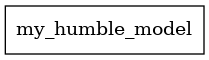

In [113]:
tf.keras.utils.plot_model(model)

## Saving and Restoring a Model

In [114]:
# delete the directory if it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [115]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


In [116]:
# show the contents of the my_keras_model/ directory
from pathlib import Path

for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/keras_metadata.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


In [117]:
model: tf.keras.Model = tf.keras.models.load_model("my_keras_model")
y_predict_main, y_predict_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 46ms/step


In [118]:
model.save_weights("my_weights")

In [119]:
model.load_weights("my_weights")

In [120]:
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks 

In [121]:
import shutil

shutil.rmtree("my_checkpoints", ignore_errors=True)

In [122]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints", save_weights_only=True
)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb],
)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 5.2614 - output_1_loss: 5.6353 - output_2_loss: 1.8961 - output_1_root_mean_squared_error: 2.3739 - output_2_root_mean_squared_error: 1.3770 - val_loss: 2.2168 - val_output_1_loss: 2.1106 - val_output_2_loss: 3.1734 - val_output_1_root_mean_squared_error: 1.4528 - val_output_2_root_mean_squared_error: 1.7814
Epoch 2/10
  1/363 [..............................] - ETA: 0s - loss: 1.5532 - output_1_loss: 1.5558 - output_2_loss: 1.5298 - output_1_root_mean_squared_error: 1.2473 - output_2_root_mean_squared_error: 1.2369

363/363 [==============================] - 0s 1ms/step - loss: 1.9185 - output_1_loss: 1.9372 - output_2_loss: 1.7496 - output_1_root_mean_squared_error: 1.3918 - output_2_root_mean_squared_error: 1.3227 - val_loss: 1.9265 - val_output_1_loss: 1.7701 - val_output_2_loss: 3.3338 - val_output_1_root_mean_squared_error: 1.3304 - val_output_2_root_mean_squared_error: 1.8259
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 6.5973 - output_1_loss: 7.1255 - output_2_loss: 1.8442 - output_1_root_mean_squared_error: 2.6694 - output_2_root_mean_squared_error: 1.3580 - val_loss: 1.1133 - val_output_1_loss: 0.9173 - val_output_2_loss: 2.8771 - val_output_1_root_mean_squared_error: 0.9578 - val_output_2_root_mean_squared_error: 1.6962
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 5.5370 - output_1_loss: 5.9392 - output_2_loss: 1.9177 - output_1_root_mean_squared_error: 2.4370 - output_2_root_mean_squared_error: 1.3848 - val_loss: 50.9203 - val_ou

In [123]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
117/363 [========>.....................] - ETA: 0s - loss: 1.8352 - output_1_loss: 1.8609 - output_2_loss: 1.6035 - output_1_root_mean_squared_error: 1.3641 - output_2_root_mean_squared_error: 1.2663

363/363 [==============================] - 0s 1ms/step - loss: 3.2014 - output_1_loss: 3.3822 - output_2_loss: 1.5747 - output_1_root_mean_squared_error: 1.8391 - output_2_root_mean_squared_error: 1.2549 - val_loss: 3.1840 - val_output_1_loss: 3.3293 - val_output_2_loss: 1.8763 - val_output_1_root_mean_squared_error: 1.8246 - val_output_2_root_mean_squared_error: 1.3698
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 1.1373 - output_1_loss: 1.0994 - output_2_loss: 1.4781 - output_1_root_mean_squared_error: 1.0485 - output_2_root_mean_squared_error: 1.2158 - val_loss: 4.0329 - val_output_1_loss: 4.2914 - val_output_2_loss: 1.7059 - val_output_1_root_mean_squared_error: 2.0716 - val_output_2_root_mean_squared_error: 1.3061
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 3.5100 - output_1_loss: 3.7163 - output_2_loss: 1.6534 - output_1_root_mean_squared_error: 1.9278 - output_2_root_mean_squared_error: 1.2859 - val_loss: 1.4848 - val_o

The following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting).

In [124]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [125]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb],
    verbose=0,
)

Epoch=0, val/train=0.23
Epoch=1, val/train=3.69
Epoch=2, val/train=0.50
Epoch=3, val/train=0.87
Epoch=4, val/train=0.20
Epoch=5, val/train=0.88
Epoch=6, val/train=3.28
Epoch=7, val/train=0.31
Epoch=8, val/train=2.22
Epoch=9, val/train=2.60


## Using TensorBoard for Visualization

In [126]:
shutil.rmtree("my_logs", ignore_errors=True)

Here we define a little function that generates the path of the log subdirectory based on the current date and time, so that it is different at every run.

In [127]:
from time import strftime


def get_run_log_dir(root_log_dir="my_logs"):
    """
    Returns the path of the log subdirectory based on the current date and time.
    """
    return Path(root_log_dir) / strftime("run_%Y_%m_%d_%H_%M_%S")


run_log_dir = get_run_log_dir()

In [128]:
# builds the first regression model we used earlier
tf.random.set_seed(42)
tf.keras.backend.clear_session()
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential(
    [
        norm_layer,
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [129]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir, profile_batch=((100, 200)))
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb],
)

Epoch 1/20


2024-02-23 13:32:18.619163: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-02-23 13:32:18.619190: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-02-23 13:32:18.619479: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


 62/363 [====>.........................] - ETA: 0s - loss: 4.4753 - root_mean_squared_error: 2.1155  

235/363 [==================>...........] - ETA: 0s - loss: 2.5637 - root_mean_squared_error: 1.6012

2024-02-23 13:32:18.967348: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-02-23 13:32:18.967380: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-02-23 13:32:19.087647: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-02-23 13:32:19.095396: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-02-23 13:32:19.096064: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_02_23_13_32_18/plugins/profile/2024_02_23_13_32_19/tans-laptop.xplane.pb


363/363 [==============================] - 1s 1ms/step - loss: 2.0214 - root_mean_squared_error: 1.4217 - val_loss: 1.7953 - val_root_mean_squared_error: 1.3399
Epoch 2/20
363/363 [==============================] - 0s 930us/step - loss: 0.8104 - root_mean_squared_error: 0.9002 - val_loss: 0.7863 - val_root_mean_squared_error: 0.8867
Epoch 3/20
363/363 [==============================] - 0s 904us/step - loss: 0.6878 - root_mean_squared_error: 0.8294 - val_loss: 0.7266 - val_root_mean_squared_error: 0.8524
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6340 - root_mean_squared_error: 0.7962 - val_loss: 0.6259 - val_root_mean_squared_error: 0.7912
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5931 - root_mean_squared_error: 0.7701 - val_loss: 0.5433 - val_root_mean_squared_error: 0.7371
Epoch 6/20
363/363 [==============================] - 0s 956us/step - loss: 0.5565 - root_mean_squared_error: 0.7460 - val_loss: 0.5333 - val_root_

In [130]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_02_23_13_32_18
    plugins
      profile
        2024_02_23_13_32_19
          tans-laptop.xplane.pb
    train
      events.out.tfevents.1708669938.tans-laptop.18166.0.v2
    validation
      events.out.tfevents.1708669939.tans-laptop.18166.1.v2


In [131]:
# load the Jupyter extension for TensorBoard
%load_ext tensorboard

# start a TensorBoard server for the my_logs directory
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "http://localhost:6006/" link below.

In [132]:
from IPython.display import display, HTML

display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

In [133]:
# builds the first regression model we used earlier
tf.random.set_seed(42)
tf.keras.backend.clear_session()
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential(
    [
        norm_layer,
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=2e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [134]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir, profile_batch=((100, 200)))
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb],
)

Epoch 1/20


2024-02-23 13:32:28.935314: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-02-23 13:32:28.935356: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-02-23 13:32:28.935573: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


322/363 [=========================>....] - ETA: 0s - loss: 1.5458 - root_mean_squared_error: 1.2433

2024-02-23 13:32:29.279407: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-02-23 13:32:29.279435: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-02-23 13:32:29.359594: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-02-23 13:32:29.368302: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-02-23 13:32:29.368402: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_02_23_13_32_18/plugins/profile/2024_02_23_13_32_29/tans-laptop.xplane.pb


363/363 [==============================] - 1s 1ms/step - loss: 1.4468 - root_mean_squared_error: 1.2028 - val_loss: 1.3153 - val_root_mean_squared_error: 1.1469
Epoch 2/20
363/363 [==============================] - 0s 952us/step - loss: 0.5877 - root_mean_squared_error: 0.7666 - val_loss: 0.6615 - val_root_mean_squared_error: 0.8133
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5241 - root_mean_squared_error: 0.7240 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4840 - root_mean_squared_error: 0.6957 - val_loss: 0.4415 - val_root_mean_squared_error: 0.6644
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4573 - root_mean_squared_error: 0.6762 - val_loss: 0.4212 - val_root_mean_squared_error: 0.6490
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4381 - root_mean_squared_error: 0.6619 - val_loss: 0.4026 - val_root_mean

In [135]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_02_23_13_32_18
    plugins
      profile
        2024_02_23_13_32_19
          tans-laptop.xplane.pb
        2024_02_23_13_32_29
          tans-laptop.xplane.pb
    train
      events.out.tfevents.1708669938.tans-laptop.18166.0.v2
      events.out.tfevents.1708669948.tans-laptop.18166.2.v2
    validation
      events.out.tfevents.1708669939.tans-laptop.18166.1.v2
      events.out.tfevents.1708669949.tans-laptop.18166.3.v2


You can also visualize histograms, images, text, and even listen to audio using TensorBoard.

In [136]:
test_log_dir = get_run_log_dir()
writer = tf.summary.create_file_writer(str(test_log_dir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)

        data = (np.random.randn(100) + 2) * step / 100  # gets bigger
        tf.summary.histogram("my_histogram", data, step=step, buckets=50)

        images = np.random.rand(2, 32, 32, 3) * step / 1000
        tf.summary.image("my_image", images, step=step)

        texts = ["The steps is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)

        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

If you stop this Jupyter kernel, (a.k.a. Runtime), it will automatically stop the TensorBoard as well. If you run this in VSCode, then VSCode will automatically manage the resource (automatically kill TensorBoard when you close the program). Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX.

Then you first need to find the process ID.

In [137]:
from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:14 ago; pid 22469)


Next, you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above.
    
    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-tuning Neural Network Hyperparameters

In this section, we'll use the Fashion MNISt dataset.

In [138]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [139]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [140]:
import keras_tuner as kt
from keras_tuner import HyperParameters


def build_model(hp: HyperParameters):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"
    )
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model

In [141]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    overwrite=True,
    directory="my_fashion_mnist",
    project_name="my_rnd_search",
    seed=42,
)
random_search_tuner.search(
    X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)
)

Trial 5 Complete [00h 00m 21s]
val_accuracy: 0.8327999711036682

Best val_accuracy So Far: 0.8610000014305115
Total elapsed time: 00h 01m 45s


Here is how you get the top best models.

In [142]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

You can call `get_best_hyperparameters()` to receive the `kt.Hyperparameters` of the best models.

In [143]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

Since the oracle keeps track of all the trials, you can ask it to give you the best one, and display a summary of that trial.

In [144]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8610000014305115


In [145]:
best_trial.metrics.get_last_value("val_accuracy")

0.8610000014305115

In [146]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
 240/1875 [==>...........................] - ETA: 2s - loss: 0.3205 - accuracy: 0.8828

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3248 - accuracy: 0.8805
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3166 - accuracy: 0.8829
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3070 - accuracy: 0.8869
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3007 - accuracy: 0.8893
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2946 - accuracy: 0.8911
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2883 - accuracy: 0.8917
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2825 - accuracy: 0.8952
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2759 - accuracy: 0.8973
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2699 - accuracy: 0.8996
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.4002 - accuracy:

The following code builds the same model as before, with the same hyperparameters, but it also uses a Boolean `"normalize"` hyperparameter to control whether or not to standardize the training data before fitting the model.

In [147]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [148]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    overwrite=True,
    directory="my_fashion_mnist",
    project_name="hyperband",
)

In [149]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Trial 60 Complete [00h 00m 26s]
val_accuracy: 0.8496000170707703

Best val_accuracy So Far: 0.8813999891281128
Total elapsed time: 00h 12m 57s


In [150]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_trials=10,
    alpha=1e-4,
    beta=2.6,
    overwrite=True,
    directory="my_fashion_mnist",
    project_name="bayesian_opt",
)
bayesian_opt_tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb],
)

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.8443999886512756

Best val_accuracy So Far: 0.8587999939918518
Total elapsed time: 00h 03m 34s
